In [1]:
import cupy as cp
import numpy as np
from numpy import linspace, sign, prod, tanh, cosh, cos, tan, arange
from math import sqrt, pi
from matplotlib import pyplot as plt
import numba
from numba import prange
from functools import lru_cache

In [2]:
@numba.njit(cache=True)
def factorial(x):
    n = 1
    for i in range(2, x+1):
        n *= i
    return n

@numba.njit(cache=True)
def comb(n, k):
    return factorial(n) / (factorial(k) * factorial(n - k))


@numba.njit(cache = True)
def W(i1,j1,k1,l1,i2,j2,k2,l2,alpha,delta):
    A = 0
    for mu in range(0, i1+1):
        for nu in range(0, j1+1):
            for kappa in range(0,k1+1):
                for lamda in range(0,l1+1):
                    for na in range(0, min(j2,nu+kappa)+1):
                        for nd in range(0, min(k2,j1+k1-(nu+kappa))+1):
                            A = A + (
                                1/(sqrt(2)**(i1+j1+k1+l1) * sqrt(factorial(i1) * factorial(j1) * factorial(k1) * factorial(l1))) * 
                                (-1)**(mu+nu) * comb(i1,mu) * comb(j1,nu) * comb(k1,kappa) * comb(l1,lamda) * 
                                int(mu+nu+kappa+lamda == (i2+j2)) * int(i1+j1+k1+l1 == (i2+j2+k2+l2)) * 
                                sqrt(factorial(mu+lamda) * factorial(nu+kappa) * factorial(i1+l1-mu-lamda) * factorial(j1+k1-nu-kappa))*
                                cos(alpha/2)**(i2+j2-2*na) * cos(delta/2)**(k2+l2-2*nd) * 
                                ((1j*tan(alpha/2))**(j2+nu+kappa-2*na) * (1j*tan(delta/2))**(k2+j1+k1-nu-kappa-2*nd) / (factorial(j2-na) * factorial(nu+kappa-na) * factorial(k2-nd) * factorial(j1+k1-nu-kappa-nd)))*
                                sqrt(
                                    prod(na+arange(1, j2-na+1))* #  m1
                                    prod(na+arange(1, nu+kappa-na+1))* # m2
                                    prod(i2+arange(1, j2-na+1))* # m3
                                    prod(i2+j2-nu-kappa+arange(1, nu+kappa-na+1))* # m4
                                    prod(nd+arange(1, k2-nd+1))* # m5
                                    prod(nd+arange(1, j1+k1-nu-kappa-nd+1))* # m6
                                    prod(l2+arange(1, k2-nd+1))* # m7
                                    prod(k2+l2-j1-k1+nu+kappa+arange(1, j1+k1-nu-kappa-nd+1)) # m8
                                )
                            )
    return abs(A) ** 2

@numba.njit(cache=True)
def det_p(out, input, eta, dc):
    p = (1-dc) * (1-eta * (1-dc))**input
    if out == 1:
        p = 1-p
    return p
    
@numba.njit(cache=True)
def h(chi, eta, dc):
    return (1-eta*(1-dc)) * tanh(chi)**2

@numba.njit(cache=True)
def f(out, input, chi, eta, dc):
    if out == 0:
        ret_f = (h(chi, eta, dc)**input) * (1-h(chi, eta, dc))
    else: 
        ret_f = ( tanh(chi)**(2*input) - (1-dc) * h(chi, eta, dc)**input ) / ( cosh(chi)**2 - (1-dc)/(1-h(chi, eta, dc)) )
    return ret_f

In [3]:
# @numba.njit(parallel=True)
def run_simulations(alpha_list, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc):
    fringe = []
    for alpha in alpha_list:
        for delta in delta_list:
            Q = 0
            for input_condition in range(len(qrst_1)):
                q1 = qrst_1[input_condition][0]
                r1 = qrst_1[input_condition][1]
                s1 = qrst_1[input_condition][2]
                t1 = qrst_1[input_condition][3]
                for output_condition in range(len(qrst_2)):
                    q2 = qrst_2[output_condition][0]
                    r2 = qrst_2[output_condition][1]
                    s2 = qrst_2[output_condition][2]
                    t2 = qrst_2[output_condition][3]
                    for i2 in range(0, trunc+1):
                        for j2 in range(0, trunc+1):
                            for k2 in range(0, trunc+1):
                                for l2 in range(0, trunc+1):
                                    remote_det_p = det_p(q2, i2, eta2, dc2_1_12) * det_p(r2, j2, eta2, dc2_1_12) * det_p(s2, k2, eta2, dc2_1_12) * det_p(t2, l2, eta2, dc2_1_12)
                                    for i1 in range(0, trunc+1):
                                        for j1 in range(0, trunc+1):
                                            for k1 in range(0, trunc+1):
                                                for l1 in range(0, trunc+1):
                                                    Q = Q + (
                                                                remote_det_p * 
                                                                W(i1,j1,k1,l1,i2,j2,k2,l2,alpha,delta) * 
                                                                f(q1, i1, chi, eta1_12, dc2_1_12) * f(r1, j1, chi, eta1_12, dc2_1_12) * f(s1, k1, chi, eta1_34, dc1_34) * f(t1, l1, chi, eta1_34, dc1_34) 
                                                            )
            fringe.append(Q)
    return fringe

In [4]:
# % params
# alpha_list_1 = [0]
# alpha_list_2 = [pi/2]

alpha_list = linspace(0, pi-1e-3, 10)

delta_list = linspace(0,2*np.pi,20)
# delta_list = [np.pi/2, 3*np.pi/2]
# delta_list = [np.pi/2]

chi = sqrt(0.06)

dc1_34 = 1*10**(-5)
dc2_1_12 = 3 * 10**(-5)

eta1_12 = 0.045
eta1_34 = 0.135
eta2 = 0.04

qrst_1 = [[1,0,1,0],[0,1,0,1]]
# qrst_1 = [[1,0,1,0]]
qrst_2 = [[0,1,1,0],[1,0,0,1]]
# qrst_2 = [[0,1,1,0]]

trunc = 2

In [5]:
# Trying stuff out
# fringe1 = run_simulations(alpha_list, delta_list, chi, 0, 0, 1, 1, 1, qrst_1, qrst_2, trunc)
# fringe2 = run_simulations(alpha_list, delta_list, chi, 0, 0, 0.5, 0.5, 0.5, qrst_1, qrst_2, trunc)
# fringe3 = run_simulations(alpha_list, delta_list, chi, 0, 0, 0.005, 0.005, 0.005, qrst_1, qrst_2, trunc)

# fringe_real_1 = run_simulations(alpha_list_1, delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)
# fringe_real_2 = run_simulations(alpha_list_2, delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)

fringe_real = []
for alpha in alpha_list[:-1]:
    print(alpha)
    fringe = run_simulations([alpha], delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)
    fringe_real.append(fringe)


# Actual simulation
# fringe_real_1 = run_simulations(alpha_list_1, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc)
# fringe_real_2 = run_simulations(alpha_list_2, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc)


0.0
0.3489547392877548
0.6979094785755096
1.0468642178632643
1.3958189571510191
1.744773696438774
2.0937284357265287
2.4426831750142837
2.7916379143020382


In [6]:
# visibility1 = (max(fringe1) - min(fringe1)) / (max(fringe1) + min(fringe1))
# visibility2 = (max(fringe2) - min(fringe2)) / (max(fringe2) + min(fringe2))
# visibility3 = (max(fringe3) - min(fringe3)) / (max(fringe3) + min(fringe3))
# visibility_real_1 = (max(fringe_real_1) - min(fringe_real_1)) / (max(fringe_real_1) + min(fringe_real_1))
# visibility_real_2 = (max(fringe_real_2) - min(fringe_real_2)) / (max(fringe_real_2) + min(fringe_real_2))

# print(visibility1, visibility2, visibility3, visibility_real, fringe_real)
# print(visibility_real_1, fringe_real_1)
# print(visibility_real_2, fringe_real_2)

for i in range(len(fringe_real)):
    visibility = (max(fringe_real[i]) - min(fringe_real[i])) / (max(fringe_real[i]) + min(fringe_real[i]))
    print(visibility, fringe_real[i])

0.976759978818838 [0.009011149955342721, 0.031153982520388195, 0.09470542596153833, 0.19155503453467407, 0.30976971743910003, 0.4355029981274262, 0.5549272535556168, 0.6558021759828502, 0.7284938856785947, 0.766474370053305, 0.766474370053305, 0.728493885678595, 0.6558021759828506, 0.554927253555617, 0.4355029981274262, 0.3097697174391003, 0.19155503453467412, 0.09470542596153848, 0.031153982520388236, 0.009011149955342721]
0.9744714553632126 [0.033636087341515825, 0.01002467584093139, 0.030291820001118106, 0.09100279271812972, 0.1841278695916951, 0.2985370156971616, 0.42164339501974135, 0.5408336657813885, 0.6445141733404145, 0.7228075718902418, 0.7680622525722464, 0.7753452685534298, 0.7429936452209613, 0.6731531362439919, 0.5721038127560515, 0.4501158179366475, 0.3206310860463661, 0.1987283640457263, 0.0990568079879753, 0.03363608734151586]
0.9685448383532096 [0.10395632260284608, 0.037616084726215616, 0.012643694548234758, 0.030490043238931196, 0.08774748451664809, 0.17715481166684

[0.009011149955342721, 0.031153982520388195, 0.09470542596153833, 0.19155503453467407, 0.30976971743910003, 0.4355029981274262, 0.5549272535556168, 0.6558021759828502, 0.7284938856785947, 0.766474370053305, 0.766474370053305, 0.728493885678595, 0.6558021759828506, 0.554927253555617, 0.4355029981274262, 0.3097697174391003, 0.19155503453467412, 0.09470542596153848, 0.031153982520388236, 0.009011149955342721]
[0.033636087341515825, 0.01002467584093139, 0.030291820001118106, 0.09100279271812972, 0.1841278695916951, 0.2985370156971616, 0.42164339501974135, 0.5408336657813885, 0.6445141733404145, 0.7228075718902418, 0.7680622525722464, 0.7753452685534298, 0.7429936452209613, 0.6731531362439919, 0.5721038127560515, 0.4501158179366475, 0.3206310860463661, 0.1987283640457263, 0.0990568079879753, 0.03363608734151586]
[0.10395632260284608, 0.037616084726215616, 0.012643694548234758, 0.030490043238931196, 0.08774748451664809, 0.17715481166684544, 0.2888337910339812, 0.411429895903341, 0.5330127558

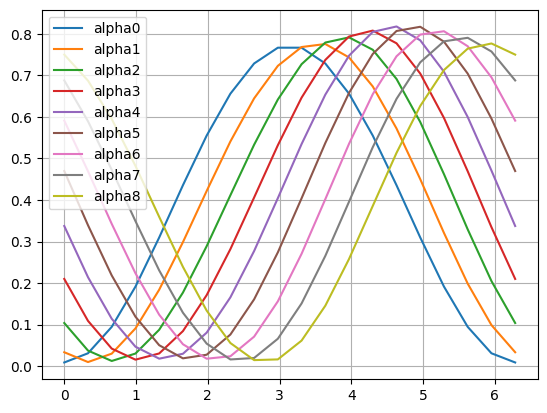

In [7]:
# plt.grid(True)
# plt.plot(delta_list, fringe1)

# plt.figure()
# plt.grid(True)
# plt.plot(delta_list, fringe2)

# plt.figure()
# plt.grid(True)
# plt.plot(delta_list, fringe3)

plt.figure()
plt.grid(True)
for i in range(len(alpha_list)-1):
    print(fringe_real[i])
    plt.plot(delta_list, fringe_real[i], label=f'alpha{i}')
plt.legend()


In [8]:
# % params
# alpha_list_1 = [0]
# alpha_list_2 = [pi/2]

alpha_list = linspace(0, pi-1e-3, 10)

delta_list = linspace(0,2*np.pi,20)
# delta_list = [np.pi/2, 3*np.pi/2]
# delta_list = [np.pi/2]

chi = sqrt(0.06)

dc1_34 = 1*10**(-5)
dc2_1_12 = 3 * 10**(-5)

eta1_12 = 0.045
eta1_34 = 0.135
eta2 = 0.04

qrst_1 = [[1,0,1,0],[0,1,0,1]]
# qrst_1 = [[1,0,1,0]]
qrst_2 = [[0,1,1,0],[1,0,0,1]]
# qrst_2 = [[0,1,1,0]]

trunc = 3

In [9]:
# Trying stuff out
# fringe1 = run_simulations(alpha_list, delta_list, chi, 0, 0, 1, 1, 1, qrst_1, qrst_2, trunc)
# fringe2 = run_simulations(alpha_list, delta_list, chi, 0, 0, 0.5, 0.5, 0.5, qrst_1, qrst_2, trunc)
# fringe3 = run_simulations(alpha_list, delta_list, chi, 0, 0, 0.005, 0.005, 0.005, qrst_1, qrst_2, trunc)

# fringe_real_1 = run_simulations(alpha_list_1, delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)
# fringe_real_2 = run_simulations(alpha_list_2, delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)

fringe_real = []
for alpha in alpha_list[:-1]:
    print(alpha)
    fringe = run_simulations([alpha], delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)
    fringe_real.append(fringe)


# Actual simulation
# fringe_real_1 = run_simulations(alpha_list_1, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc)
# fringe_real_2 = run_simulations(alpha_list_2, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc)


0.0
0.3489547392877548
0.6979094785755096
1.0468642178632643
1.3958189571510191
1.744773696438774
2.0937284357265287
2.4426831750142837
2.7916379143020382


In [10]:
# visibility1 = (max(fringe1) - min(fringe1)) / (max(fringe1) + min(fringe1))
# visibility2 = (max(fringe2) - min(fringe2)) / (max(fringe2) + min(fringe2))
# visibility3 = (max(fringe3) - min(fringe3)) / (max(fringe3) + min(fringe3))
# visibility_real_1 = (max(fringe_real_1) - min(fringe_real_1)) / (max(fringe_real_1) + min(fringe_real_1))
# visibility_real_2 = (max(fringe_real_2) - min(fringe_real_2)) / (max(fringe_real_2) + min(fringe_real_2))

# print(visibility1, visibility2, visibility3, visibility_real, fringe_real)
# print(visibility_real_1, fringe_real_1)
# print(visibility_real_2, fringe_real_2)

for i in range(len(fringe_real)):
    visibility = (max(fringe_real[i]) - min(fringe_real[i])) / (max(fringe_real[i]) + min(fringe_real[i]))
    print(visibility, fringe_real[i])

0.9746373447084996 [0.009877320328056638, 0.03227792046392723, 0.09650708744502069, 0.19420735271043366, 0.31314843591059816, 0.43925513267205624, 0.558626392926957, 0.6591250312223947, 0.7313453369597139, 0.7690096072852961, 0.7690096072852961, 0.731345336959714, 0.6591250312223952, 0.5586263929269573, 0.43925513267205624, 0.3131484359105984, 0.1942073527104337, 0.09650708744502083, 0.03227792046392728, 0.009877320328056638]
0.9722369669236436 [0.034788229334479656, 0.010963746744156, 0.03148176687781659, 0.0927260301172514, 0.18641890638813222, 0.3012189847401996, 0.4244446014890998, 0.5435347201304512, 0.647066224535461, 0.725370615568949, 0.7709412524525144, 0.7788452567607936, 0.7472552508147091, 0.6780449521757861, 0.5772265030239313, 0.45492364128022156, 0.32462320851828785, 0.2016301122698768, 0.10091466169166563, 0.03478822933447969]
0.9661108429573767 [0.105848847924949, 0.03887637052205166, 0.013732010302287587, 0.031755118160994834, 0.08935655290459517, 0.17910400704924878,

[0.009877320328056638, 0.03227792046392723, 0.09650708744502069, 0.19420735271043366, 0.31314843591059816, 0.43925513267205624, 0.558626392926957, 0.6591250312223947, 0.7313453369597139, 0.7690096072852961, 0.7690096072852961, 0.731345336959714, 0.6591250312223952, 0.5586263929269573, 0.43925513267205624, 0.3131484359105984, 0.1942073527104337, 0.09650708744502083, 0.03227792046392728, 0.009877320328056638]
[0.034788229334479656, 0.010963746744156, 0.03148176687781659, 0.0927260301172514, 0.18641890638813222, 0.3012189847401996, 0.4244446014890998, 0.5435347201304512, 0.647066224535461, 0.725370615568949, 0.7709412524525144, 0.7788452567607936, 0.7472552508147091, 0.6780449521757861, 0.5772265030239313, 0.45492364128022156, 0.32462320851828785, 0.2016301122698768, 0.10091466169166563, 0.03478822933447969]
[0.105848847924949, 0.03887637052205166, 0.013732010302287587, 0.031755118160994834, 0.08935655290459517, 0.17910400704924878, 0.2910231289110555, 0.4137708028464962, 0.53552602015397

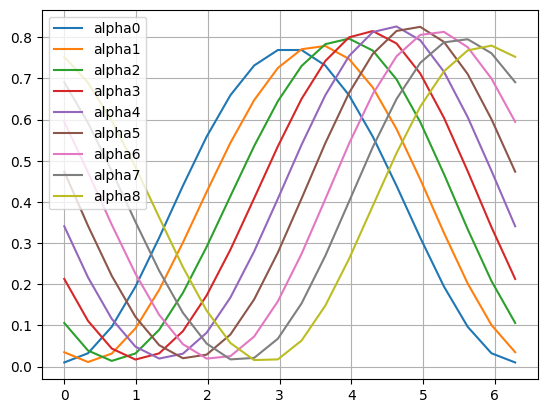

In [11]:
# plt.grid(True)
# plt.plot(delta_list, fringe1)

# plt.figure()
# plt.grid(True)
# plt.plot(delta_list, fringe2)

# plt.figure()
# plt.grid(True)
# plt.plot(delta_list, fringe3)

plt.figure()
plt.grid(True)
for i in range(len(alpha_list)-1):
    print(fringe_real[i])
    plt.plot(delta_list, fringe_real[i], label=f'alpha{i}')
plt.legend()
